# LSTM boxcox lambda = 1.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
import h5py 
import os 
import kerastuner as kt 
import IPython 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')
# , 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m'
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m']
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  500000

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'pxpy', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'meanmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.1368683772161603e-13


In [3]:
# Create X and test array
split = int(np.floor(0.9*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(450000, 6, 5) (450000, 6) (450000, 8)
(50000, 6, 5) (50000, 6) (50000, 8)


In [4]:
# Histograms of total  Y variables 
show = False

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

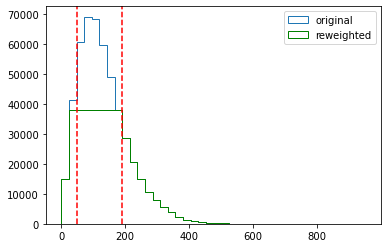

In [6]:
th_pt = np.array(dataset.get('th_pt'))[0:crop0]
hist1, bins = np.histogram(th_pt, 40)
hist1 = hist1 + (hist1<=0)*1
bins[-1] = np.inf
plt.hist(th_pt, 40, histtype='step', label='original')
argright = 8
argleft = 2
right = bins[argright]
left = bins[argleft]
compare_min = hist1[argright-1]
plt.axvline(x=left, color='r', linestyle='--')
plt.axvline(x=right, color='r', linestyle='--')
flat = 1
belong = np.digitize(th_pt, bins) - 1
factor = compare_min/hist1*(hist1>=compare_min) + (hist1<compare_min)
weight = factor[belong]
plt.hist(th_pt, bins, histtype='step', label='reweighted', color='g', weights=weight)
plt.legend()

In [7]:
# Build model

def build_model(hp):
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu')(concat0)
    for i in range(hp.Int('n_PreDense1', 1,3)):
        PreDense1 = Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense1)
    Norm = Lambda(lambda x: tf.math.multiply(x, 4))(PreDense3) # 4 relevant jets
    Shape_Dot = Reshape((-1,1))(Norm)
    Dot_jets = Multiply()([Shape_Dot, Mask])
    
    TDDense11 = TimeDistributed(Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu'))(Dot_jets)
    for i in range(hp.Int('n_TDDense11', 1,3)):
        TDDense11 = TimeDistributed(Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu'))(TDDense11)
    Sum = Flatten()(TDDense11)
    # Sum = Lambda(lambda x: tf.reduce_sum(x,1))(TDDense12)
    for i in range(hp.Int('n_Sum', 1,3)):
        Sum = Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu')(Sum)
    flat_right = Flatten()(Sum)
    
    
    Dense21 = Dense(hp.Int('input_units', min_value=32, max_value=256, step=16), activation='relu')(other_input)
    for i in range(hp.Int('n_Dense21', 1,3)):
        Dense21 = Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu')(Dense21)
    flat_other = Flatten()(Dense21)
    
    concat = concatenate([flat_other, flat_right])
    dense1 = Dense(hp.Int('input_units', min_value=64, max_value=512, step=32), activation='relu')(concat)
    for i in range(hp.Int('n_dense1', 1,3)):
        dense1 = Dense(hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense1)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 5e-5, 2.5e-5, 1e-5,5e-6,1e-6]))
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

tuner = kt.Hyperband(build_model,
                     objective = 'val_mse', 
                     max_epochs = 10,
                     factor = 3,
                     directory = './tuners',
                     project_name = 'dotjets_parasearch')  

INFO:tensorflow:Reloading Oracle from existing project ./tuners/dotjets_parasearch/oracle.json
INFO:tensorflow:Reloading Tuner from ./tuners/dotjets_parasearch/tuner0.json


In [8]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

tuner.search([trainX_jets, trainX_other], trainY, epochs = 10, validation_data = ([testX_jets, testX_other], testY), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

INFO:tensorflow:Oracle triggered exit


In [9]:
model = tuner.hypermodel.build(best_hps)

K.set_value(model.optimizer.learning_rate, 0.5e-5)
print("Learning rate: {}".format(K.eval(model.optimizer.lr)))
model.summary()




Learning rate: 4.999999873689376e-06
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 30)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 36)           0           input_2[0][0]                    
                                                         

In [10]:
# Build the model with the optimal hyperparameters and train it on the data



callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
Epochs= 512
history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_data=([testX_jets, testX_other], testY), shuffle=False, callbacks=[callback],
                   batch_size=512)

Train on 450000 samples, validate on 50000 samples
Epoch 1/512
450000/450000 [==============================] - ETA: 21:39 - loss: 0.0209 - mse: 0.02 - ETA: 2:13 - loss: 0.0211 - mse: 0.0211 - ETA: 1:16 - loss: 0.0213 - mse: 0.021 - ETA: 54s - loss: 0.0212 - mse: 0.021 - ETA: 43s - loss: 0.0211 - mse: 0.02 - ETA: 36s - loss: 0.0210 - mse: 0.02 - ETA: 31s - loss: 0.0209 - mse: 0.02 - ETA: 27s - loss: 0.0208 - mse: 0.02 - ETA: 25s - loss: 0.0208 - mse: 0.02 - ETA: 23s - loss: 0.0207 - mse: 0.02 - ETA: 21s - loss: 0.0206 - mse: 0.02 - ETA: 19s - loss: 0.0205 - mse: 0.02 - ETA: 17s - loss: 0.0204 - mse: 0.02 - ETA: 16s - loss: 0.0204 - mse: 0.02 - ETA: 15s - loss: 0.0203 - mse: 0.02 - ETA: 14s - loss: 0.0202 - mse: 0.02 - ETA: 14s - loss: 0.0202 - mse: 0.02 - ETA: 13s - loss: 0.0201 - mse: 0.02 - ETA: 12s - loss: 0.0200 - mse: 0.02 - ETA: 12s - loss: 0.0199 - mse: 0.01 - ETA: 11s - loss: 0.0199 - mse: 0.01 - ETA: 11s - loss: 0.0198 - mse: 0.01 - ETA: 10s - loss: 0.0197 - mse: 0.01 - ETA: 1

450000/450000 [==============================] - ETA: 8s - loss: 0.0088 - mse: 0.008 - ETA: 6s - loss: 0.0093 - mse: 0.009 - ETA: 6s - loss: 0.0094 - mse: 0.009 - ETA: 6s - loss: 0.0095 - mse: 0.009 - ETA: 6s - loss: 0.0094 - mse: 0.009 - ETA: 6s - loss: 0.0093 - mse: 0.009 - ETA: 6s - loss: 0.0093 - mse: 0.009 - ETA: 6s - loss: 0.0092 - mse: 0.009 - ETA: 6s - loss: 0.0092 - mse: 0.009 - ETA: 6s - loss: 0.0091 - mse: 0.009 - ETA: 5s - loss: 0.0091 - mse: 0.009 - ETA: 5s - loss: 0.0091 - mse: 0.009 - ETA: 5s - loss: 0.0091 - mse: 0.009 - ETA: 5s - loss: 0.0090 - mse: 0.009 - ETA: 5s - loss: 0.0090 - mse: 0.009 - ETA: 5s - loss: 0.0090 - mse: 0.009 - ETA: 5s - loss: 0.0090 - mse: 0.009 - ETA: 5s - loss: 0.0089 - mse: 0.008 - ETA: 5s - loss: 0.0089 - mse: 0.008 - ETA: 5s - loss: 0.0089 - mse: 0.008 - ETA: 5s - loss: 0.0089 - mse: 0.008 - ETA: 5s - loss: 0.0088 - mse: 0.008 - ETA: 5s - loss: 0.0088 - mse: 0.008 - ETA: 5s - loss: 0.0088 - mse: 0.008 - ETA: 5s - loss: 0.0088 - mse: 0.008 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0070 - mse: 0.007 - ETA: 6s - loss: 0.0074 - mse: 0.007 - ETA: 6s - loss: 0.0075 - mse: 0.007 - ETA: 6s - loss: 0.0075 - mse: 0.007 - ETA: 5s - loss: 0.0075 - mse: 0.007 - ETA: 5s - loss: 0.0075 - mse: 0.007 - ETA: 5s - loss: 0.0075 - mse: 0.007 - ETA: 5s - loss: 0.0075 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 5s - loss: 0.0074 - mse: 0.007 - ETA: 4s - loss: 0.0074 - mse: 0.007 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0071 - mse: 0.007 - ETA: 6s - loss: 0.0072 - mse: 0.007 - ETA: 6s - loss: 0.0073 - mse: 0.007 - ETA: 6s - loss: 0.0072 - mse: 0.007 - ETA: 6s - loss: 0.0072 - mse: 0.007 - ETA: 6s - loss: 0.0072 - mse: 0.007 - ETA: 5s - loss: 0.0072 - mse: 0.007 - ETA: 6s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - ETA: 5s - loss: 0.0071 - mse: 0.007 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0071 - mse: 0.007 - ETA: 6s - loss: 0.0071 - mse: 0.007 - ETA: 6s - loss: 0.0070 - mse: 0.007 - ETA: 6s - loss: 0.0071 - mse: 0.007 - ETA: 6s - loss: 0.0070 - mse: 0.007 - ETA: 6s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - ETA: 5s - loss: 0.0070 - mse: 0.007 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0066 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0070 - mse: 0.007 - ETA: 6s - loss: 0.0070 - mse: 0.007 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - ETA: 5s - loss: 0.0069 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0065 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0069 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - ETA: 5s - loss: 0.0068 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 10s - loss: 0.0065 - mse: 0.00 - ETA: 6s - loss: 0.0067 - mse: 0.0067 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 6s - loss: 0.0068 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - 

450000/450000 [==============================] - ETA: 8s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0067 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0065 - mse: 0.006 - ETA: 6s - loss: 0.0066 - mse: 0.006 - ETA: 6s - loss: 0.0067 - mse: 0.006 - ETA: 6s - loss: 0.0066 - mse: 0.006 - ETA: 6s - loss: 0.0066 - mse: 0.006 - ETA: 6s - loss: 0.0066 - mse: 0.006 - ETA: 6s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0065 - mse: 0.006 - ETA: 6s - loss: 0.0066 - mse: 0.006 - ETA: 6s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0066 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0065 - mse: 0.006 - ETA: 6s - loss: 0.0066 - mse: 0.006 - ETA: 6s - loss: 0.0065 - mse: 0.006 - ETA: 6s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0065 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0065 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0064 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0064 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - ETA: 5s - loss: 0.0063 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0063 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0062 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0062 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 4s - loss: 0.0061 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0061 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0060 - mse: 0.006 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0060 - mse: 0.006 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0059 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 10s - loss: 0.0055 - mse: 0.00 - ETA: 6s - loss: 0.0057 - mse: 0.0057 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0059 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0058 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0058 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0057 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 4s - loss: 0.0056 - mse: 0.005 - ETA: 4s - loss: 0.0056 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 10s - loss: 0.0053 - mse: 0.00 - ETA: 6s - loss: 0.0055 - mse: 0.0055 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0057 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0056 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 4s - loss: 0.0055 - mse: 0.005 - ETA: 4s - loss: 0.0055 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0056 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0055 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0055 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 4s - loss: 0.0054 - mse: 0.005 - ETA: 4s - loss: 0.0054 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0054 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0054 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 4s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0053 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 4s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 4s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 4s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0052 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 4s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0051 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0051 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 6s - loss: 0.0049 - mse: 0.0049 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 4s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - E

450000/450000 [==============================] - ETA: 10s - loss: 0.0045 - mse: 0.00 - ETA: 6s - loss: 0.0048 - mse: 0.0048 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0050 - mse: 0.005 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0050 - mse: 0.005 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 11s - loss: 0.0045 - mse: 0.00 - ETA: 6s - loss: 0.0048 - mse: 0.0048 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 8s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 4s - loss: 0.0049 - mse: 0.004 - ETA: 4s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 10s - loss: 0.0045 - mse: 0.00 - ETA: 6s - loss: 0.0048 - mse: 0.0048 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 8s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 4s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 4s - loss: 0.0049 - mse: 0.004 - ETA: 4s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0049 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0049 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0048 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0048 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0048 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 11s - loss: 0.0042 - mse: 0.00 - ETA: 8s - loss: 0.0046 - mse: 0.0046 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 9s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0042 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 13s - loss: 0.0042 - mse: 0.00 - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 8s - loss: 0.0046 - mse: 0.0046 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 21s - loss: 0.0042 - mse: 0.00 - ETA: 9s - loss: 0.0046 - mse: 0.0046 - ETA: 11s - loss: 0.0046 - mse: 0.00 - ETA: 9s - loss: 0.0046 - mse: 0.0046 - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 -

450000/450000 [==============================] - ETA: 18s - loss: 0.0042 - mse: 0.00 - ETA: 12s - loss: 0.0044 - mse: 0.00 - ETA: 12s - loss: 0.0045 - mse: 0.00 - ETA: 11s - loss: 0.0046 - mse: 0.00 - ETA: 10s - loss: 0.0047 - mse: 0.00 - ETA: 11s - loss: 0.0047 - mse: 0.00 - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 10s - loss: 0.0047 - mse: 0.00 - ETA: 10s - loss: 0.0047 - mse: 0.00 - ETA: 9s - loss: 0.0047 - mse: 0.0047 - ETA: 10s - loss: 0.0047 - mse: 0.00 - ETA: 9s - loss: 0.0047 - mse: 0.0047 - ETA: 9s - loss: 0.0046 - mse: 0.004 - ETA: 9s - loss: 0.0046 - mse: 0.004 - ETA: 9s - loss: 0.0046 - mse: 0.004 - ETA: 9s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0047 - mse: 0.004 -

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 11s - loss: 0.0042 - mse: 0.00 - ETA: 8s - loss: 0.0046 - mse: 0.0046 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 13s - loss: 0.0042 - mse: 0.00 - ETA: 6s - loss: 0.0045 - mse: 0.0045 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0047 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0042 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0042 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 8s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0047 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 11s - loss: 0.0046 - mse: 0.00 - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 9s - loss: 0.0046 - mse: 0.0046 - ETA: 9s - loss: 0.0047 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 6s - loss: 0.0042 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 14s - loss: 0.0046 - mse: 0.00 - ETA: 11s - loss: 0.0047 - mse: 0.00 - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 10s - loss: 0.0046 - mse: 0.00 - ETA: 9s - loss: 0.0046 - mse: 0.0046 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 5s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0047 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 10s - loss: 0.0041 - mse: 0.00 - ETA: 7s - loss: 0.0046 - mse: 0.0046 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 7s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0047 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 10s - loss: 0.0044 - mse: 0.00 - ETA: 9s - loss: 0.0045 - mse: 0.0045 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 14s - loss: 0.0041 - mse: 0.00 - ETA: 12s - loss: 0.0044 - mse: 0.00 - ETA: 8s - loss: 0.0045 - mse: 0.0045 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 46s - loss: 0.0041 - mse: 0.00 - ETA: 11s - loss: 0.0045 - mse: 0.00 - ETA: 9s - loss: 0.0045 - mse: 0.0045 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 9s - loss: 0.0046 - mse: 0.004 - ETA: 8s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 27s - loss: 0.0041 - mse: 0.00 - ETA: 8s - loss: 0.0045 - mse: 0.0045 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 7s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0046 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0046 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0041 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0046 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 10s - loss: 0.0040 - mse: 0.00 - ETA: 6s - loss: 0.0044 - mse: 0.0044 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - 

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 9s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 6s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0045 - mse: 0.004 - ETA: 4s - loss: 0.0044 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 8s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 6s - loss: 0.0043 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0044 - mse: 0.004 - ETA: 6s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - E

450000/450000 [==============================] - ETA: 7s - loss: 0.0040 - mse: 0.004 - ETA: 5s - loss: 0.0043 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0045 - mse: 0.004 - ETA: 5s - loss: 0.0044 - mse: 0.004 - E

Text(0.5, 1.0, 'MSE loss')

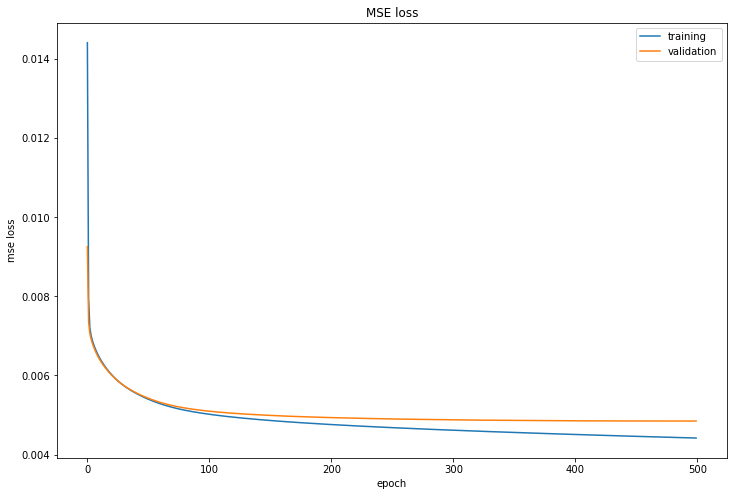

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [12]:
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

In [13]:
# np.save('true', predictions_origscale)
# np.save('pred', true_origscale)

# Training scale plots 

In [14]:
import analysis

Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0048495590558256755
 
th_px MSE :  0.0031310358
th_py MSE :  0.0053007832
th_eta MSE :  0.0088492259
th_m MSE :  0.0039114152
tl_px MSE :  0.0037422069
tl_py MSE :  0.0027297559
tl_eta MSE :  0.0064879684
tl_m MSE :  0.0046440810


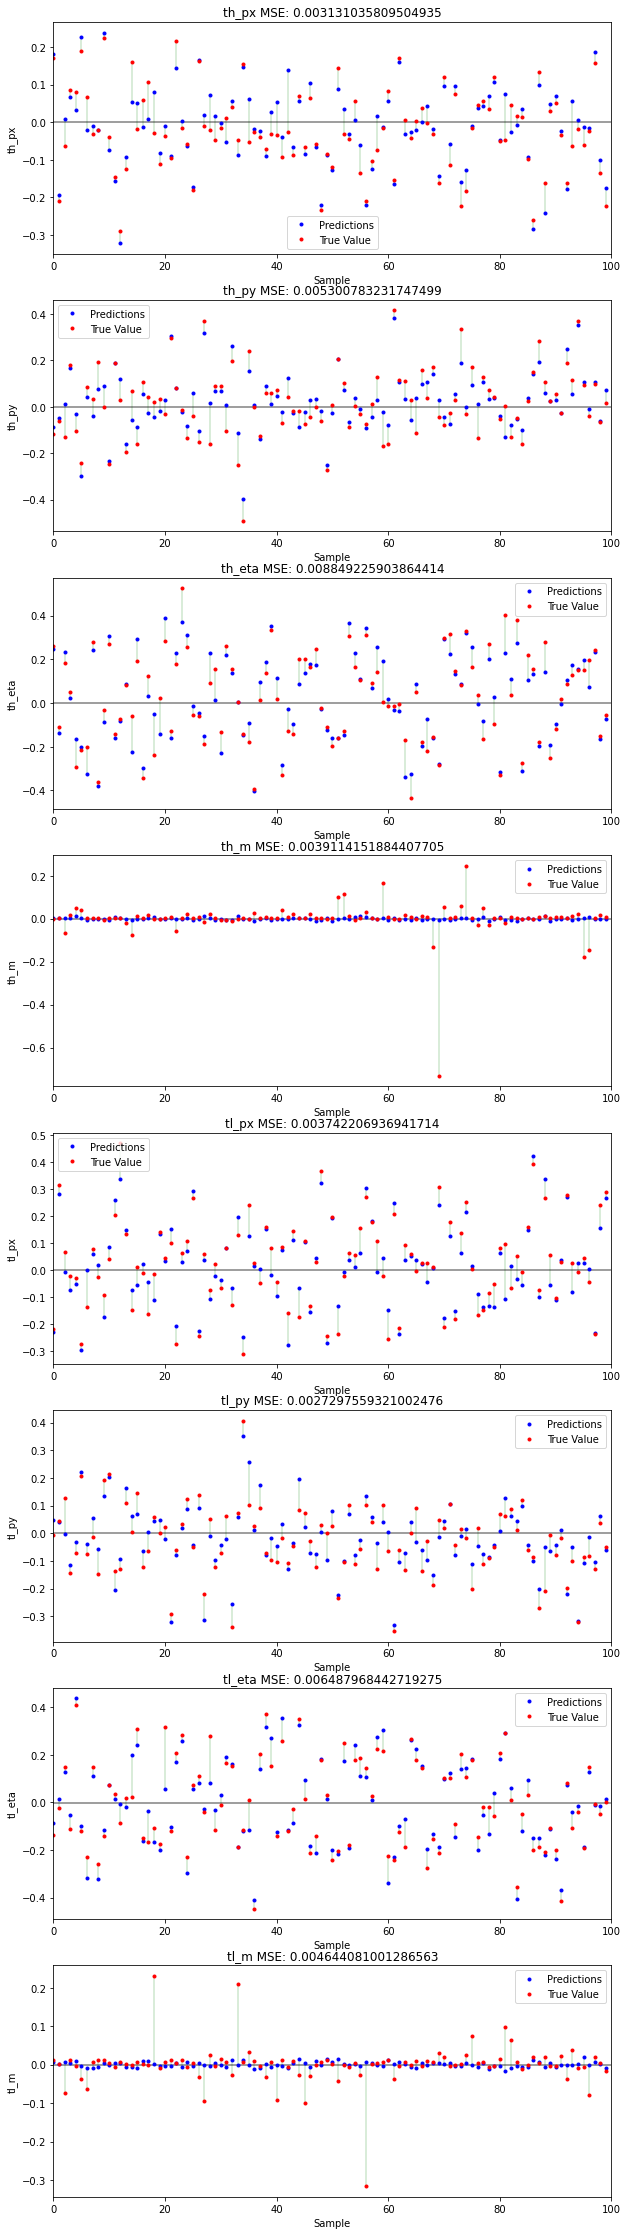

In [15]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

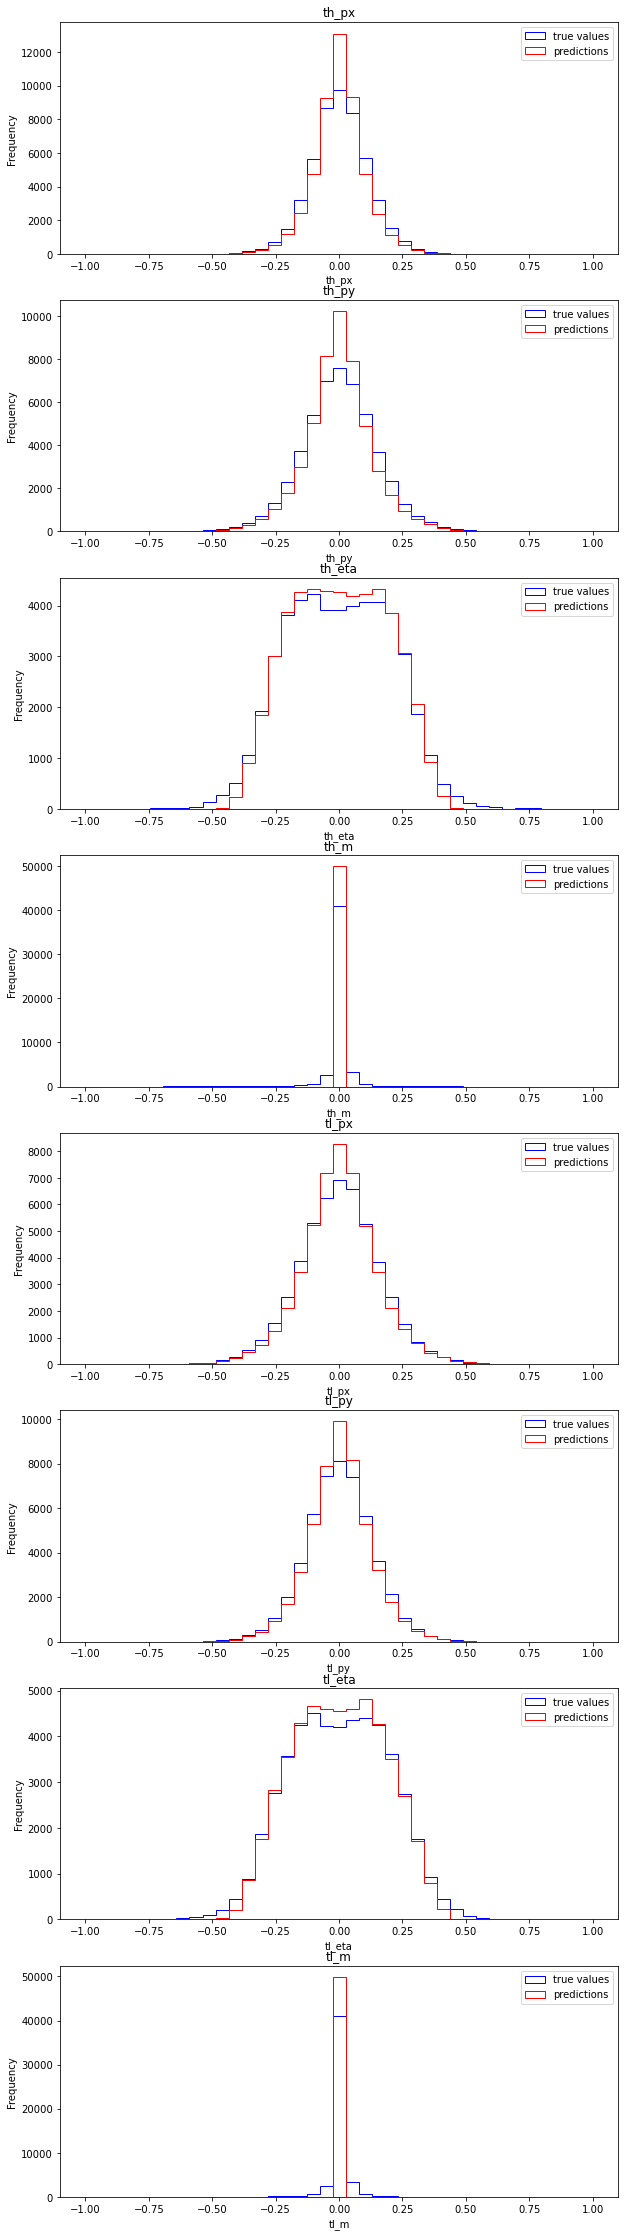

In [16]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

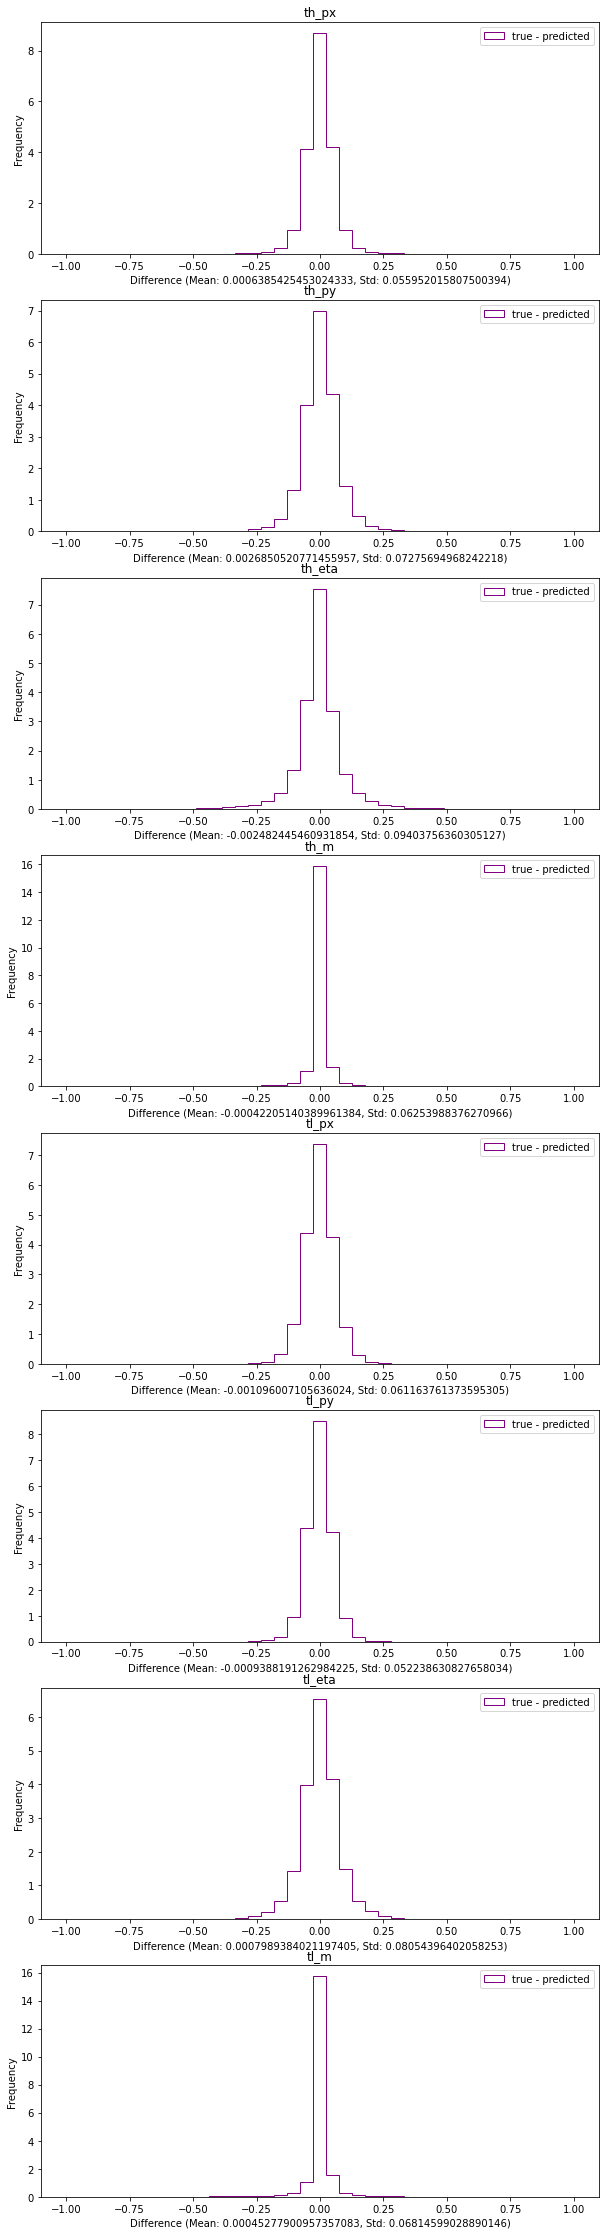

In [17]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

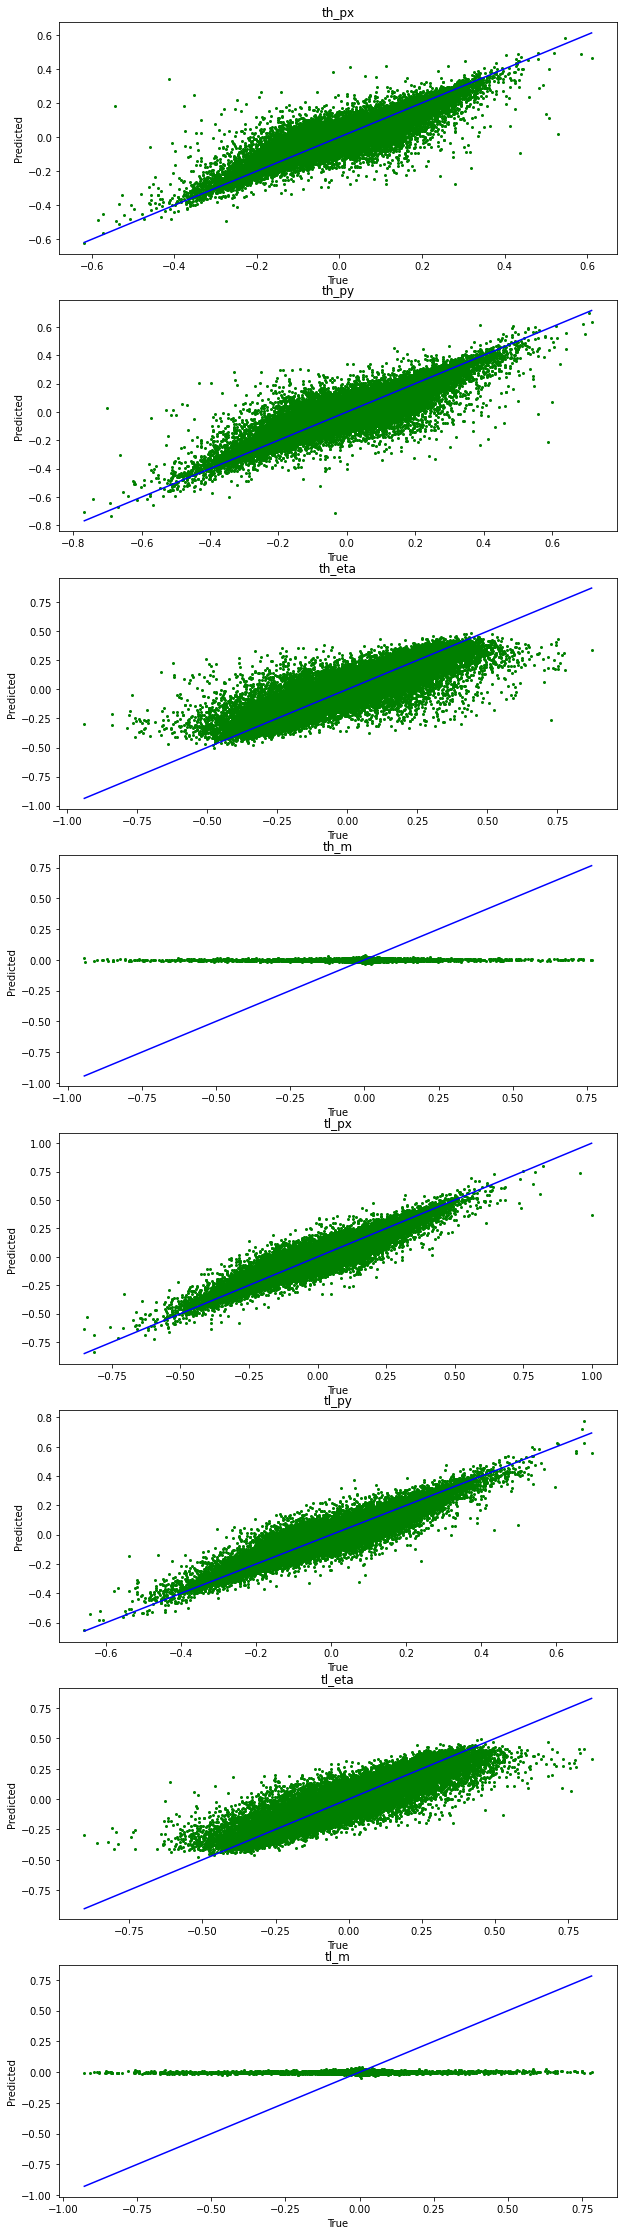

In [18]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [19]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 535.1791715426045
 
th_pt MSE :  2548.0784421912
th_eta MSE :  0.5248749869
th_phi MSE :  0.8031813895
th_m MSE :  32.8176107775
tl_pt MSE :  1655.5966498648
tl_eta MSE :  0.4094484817
tl_phi MSE :  0.5134790938
tl_m MSE :  39.0522269445


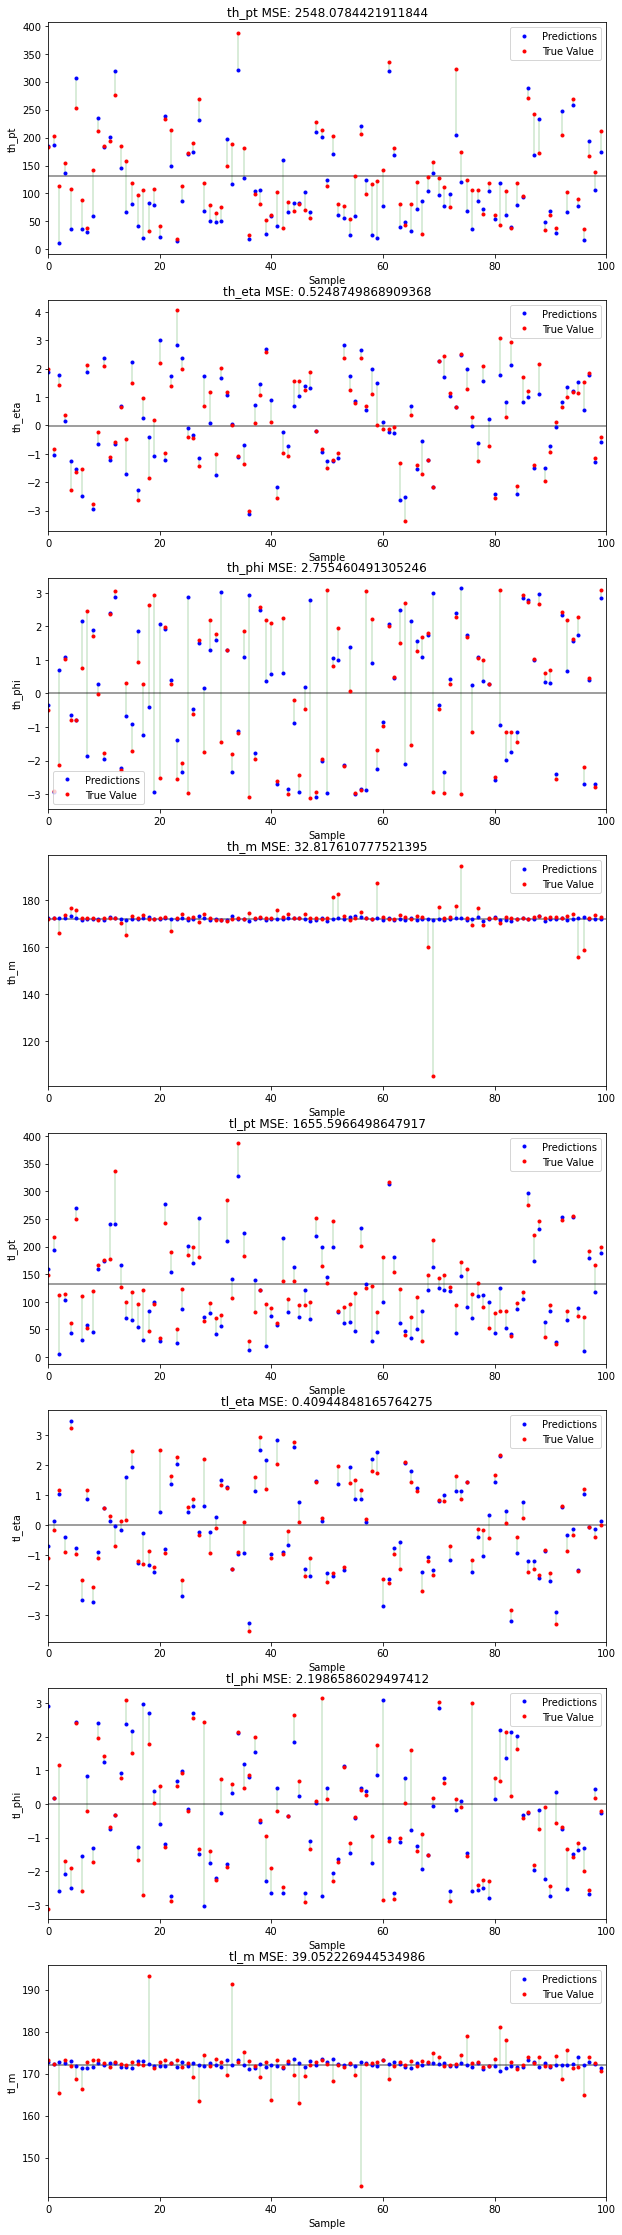

In [20]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

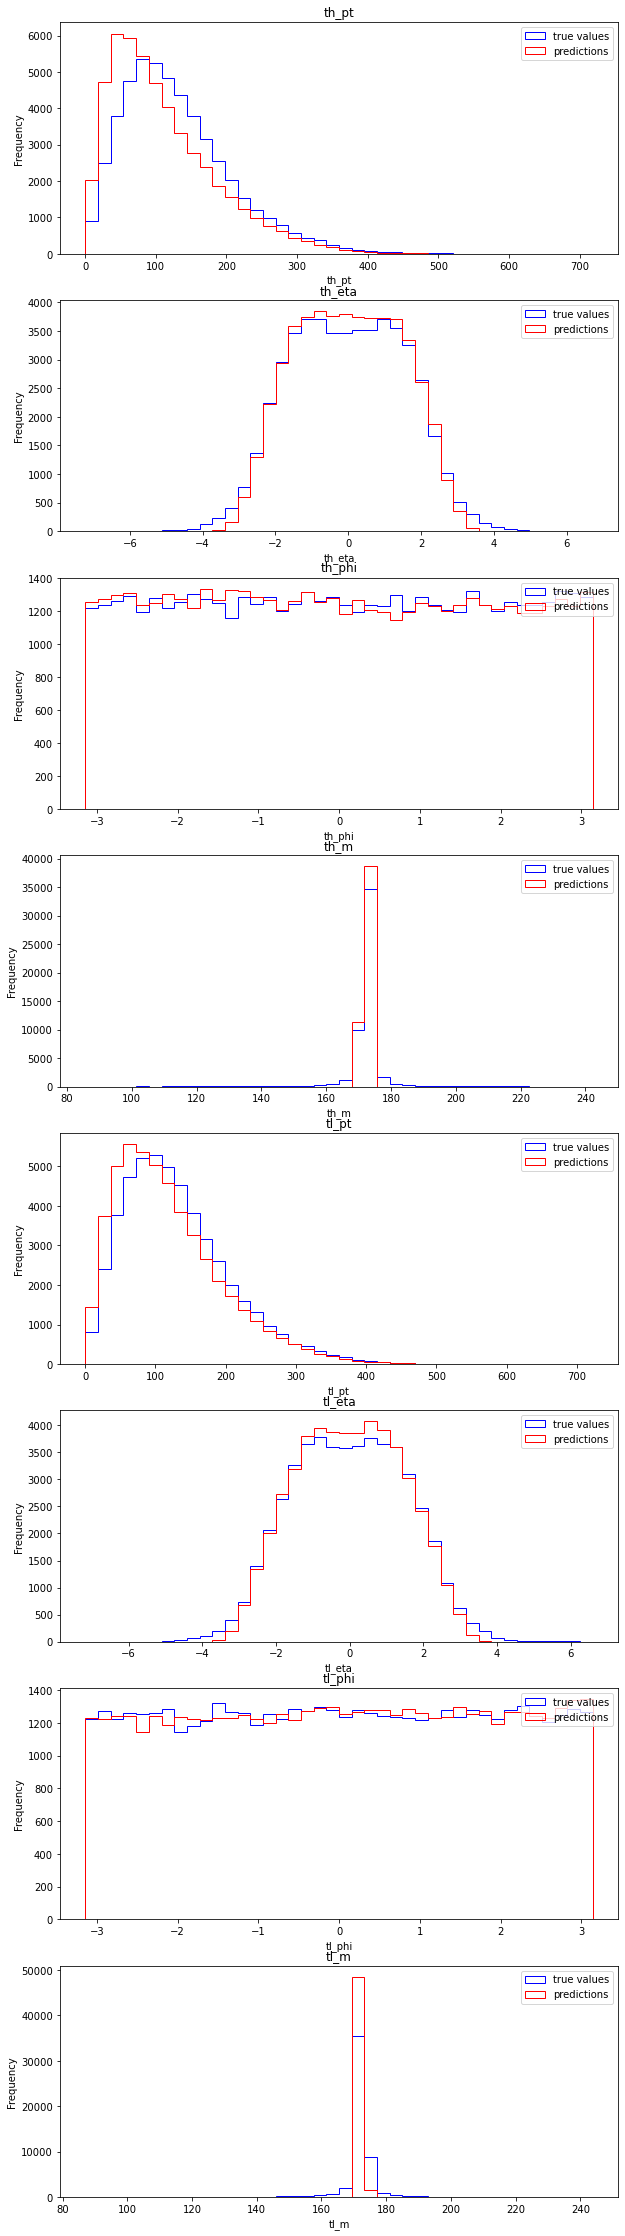

In [21]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

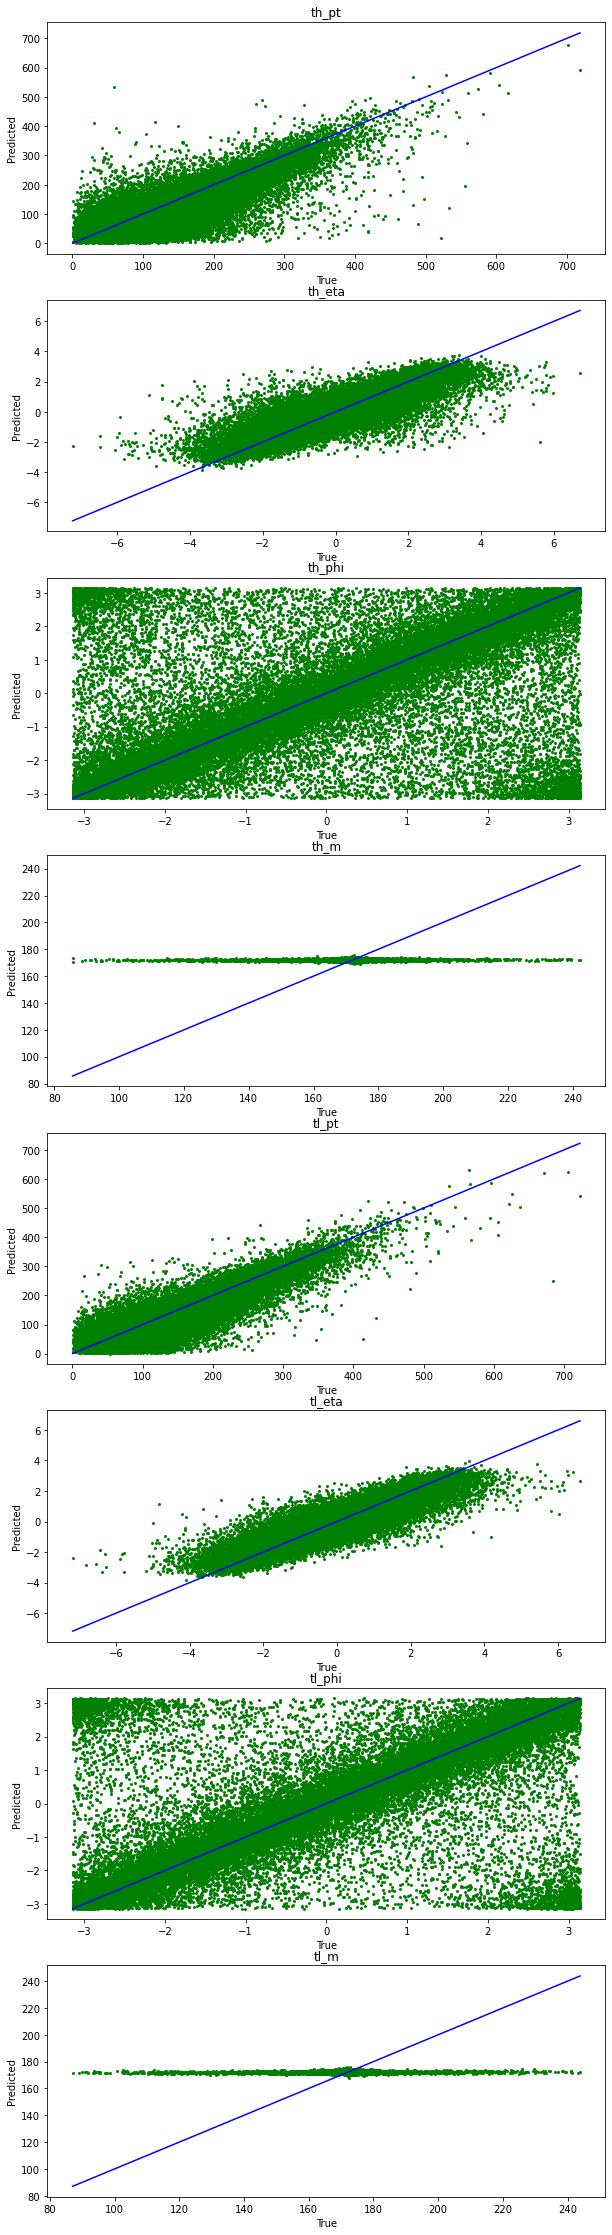

In [22]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

# Observables

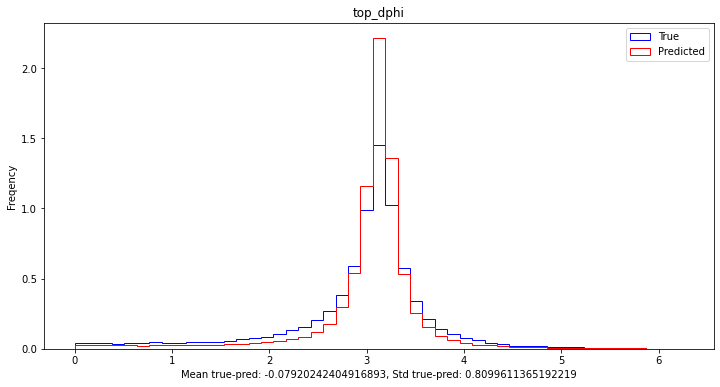

In [23]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

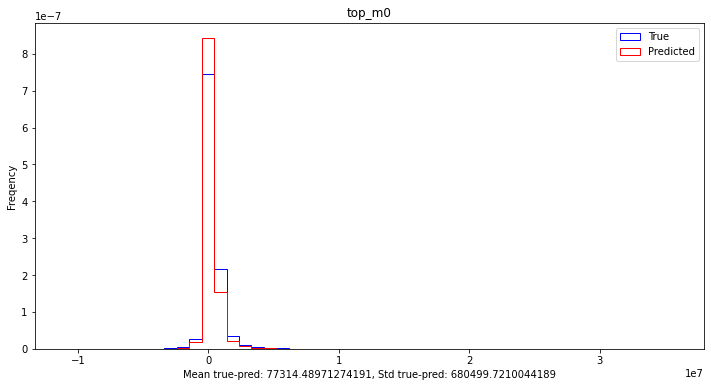

In [24]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

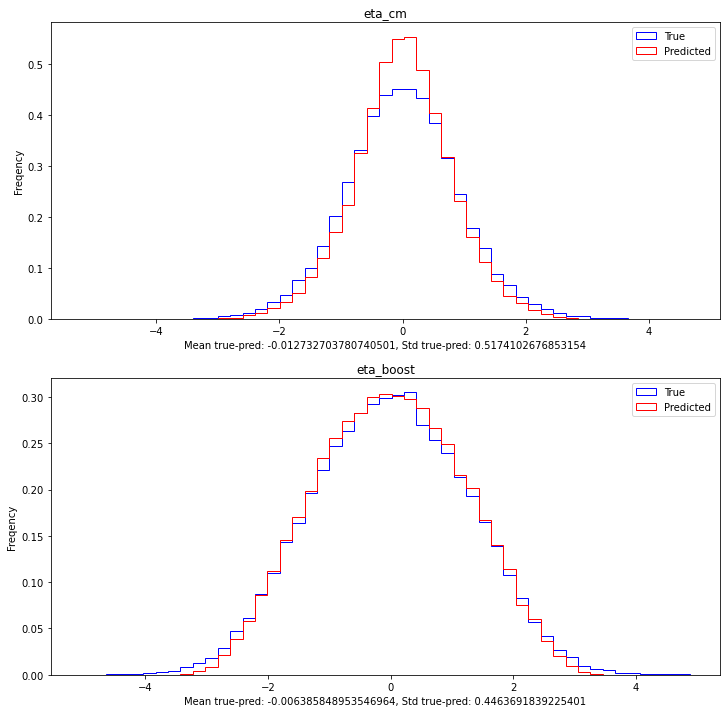

In [25]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


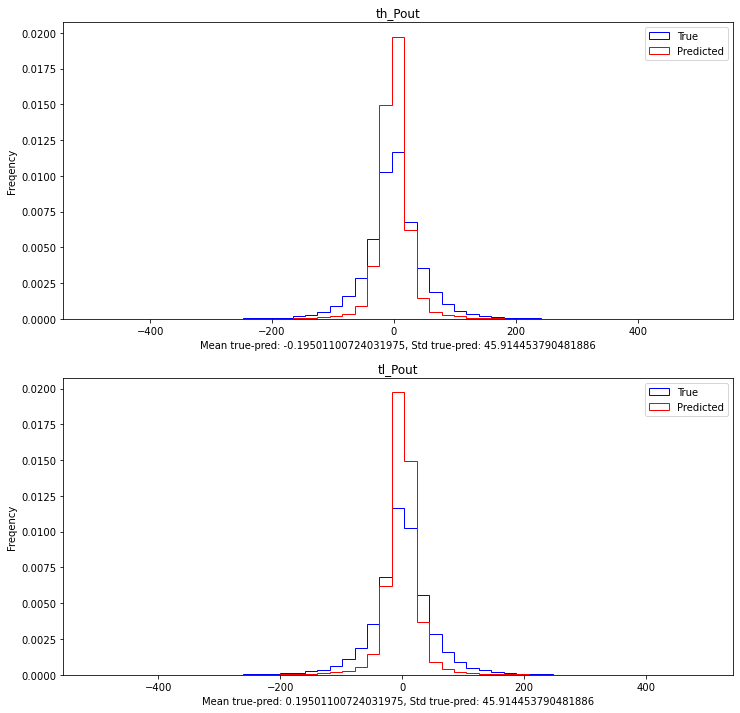

In [26]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])


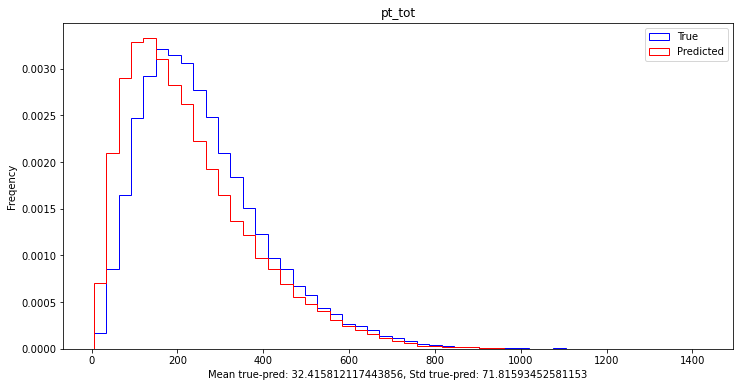

In [27]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])

In [28]:
model.save('dotjets_parasearch.keras')